In [34]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
from random import gauss
from random import seed
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

import pandas as pd
import pandas_datareader.data as web

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller

from sklearn.metrics import mean_squared_error

from scipy.stats import probplot, moment

from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

import matplotlib.pyplot as plt
import seaborn as sns

seed(42)

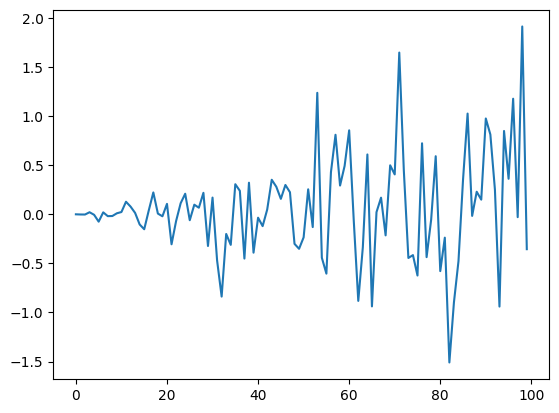

In [36]:
data = [gauss(0, i*0.01) for i in range(0,100)]

# plot
plt.plot(data)
plt.show()

In [42]:
len(data)

100

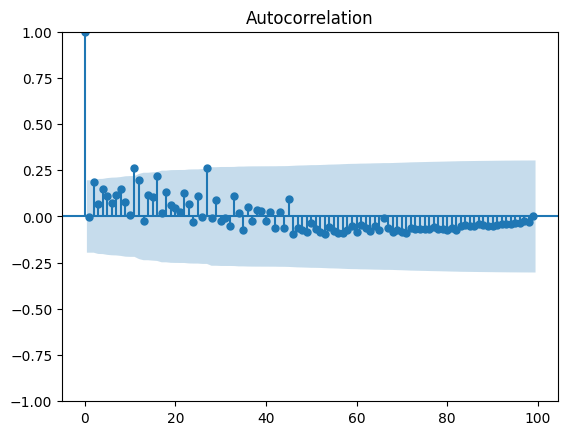

In [41]:
squared_data = np.array([x**2 for x in data])
plot_acf(squared_data, lags=len(data) - 1)
plt.show()

In [44]:
n_test = 10
train, test = data[:-n_test], data[-n_test:]

In [52]:
model = arch_model(train, mean='Zero', vol='GARCH', p=15, q=15).fit()

Iteration:      1,   Func. Count:     33,   Neg. LLF: 123.48934012644351
Iteration:      2,   Func. Count:     70,   Neg. LLF: 446874.9154398372
Iteration:      3,   Func. Count:    103,   Neg. LLF: 326.56190389441
Iteration:      4,   Func. Count:    136,   Neg. LLF: 109.13958303253932
Iteration:      5,   Func. Count:    169,   Neg. LLF: 85.62588429436938
Iteration:      6,   Func. Count:    202,   Neg. LLF: 75.66361675572863
Iteration:      7,   Func. Count:    235,   Neg. LLF: 54.506820750175955
Iteration:      8,   Func. Count:    268,   Neg. LLF: 150.53356343998854
Iteration:      9,   Func. Count:    301,   Neg. LLF: 45.2366896358609
Iteration:     10,   Func. Count:    334,   Neg. LLF: 37.384216102371695
Iteration:     11,   Func. Count:    367,   Neg. LLF: 34.35270331395765
Iteration:     12,   Func. Count:    399,   Neg. LLF: 34.05009633630543
Iteration:     13,   Func. Count:    432,   Neg. LLF: 37.443344585965534
Iteration:     14,   Func. Count:    465,   Neg. LLF: 32.8505

In [53]:
print(model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.011
Vol Model:                      GARCH   Log-Likelihood:               -32.6797
Distribution:                  Normal   AIC:                           127.359
Method:            Maximum Likelihood   BIC:                           204.854
                                        No. Observations:                   90
Date:                Fri, May 10 2024   Df Residuals:                       90
Time:                        15:28:50   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0119  3.348e-02      0.356      0.722 

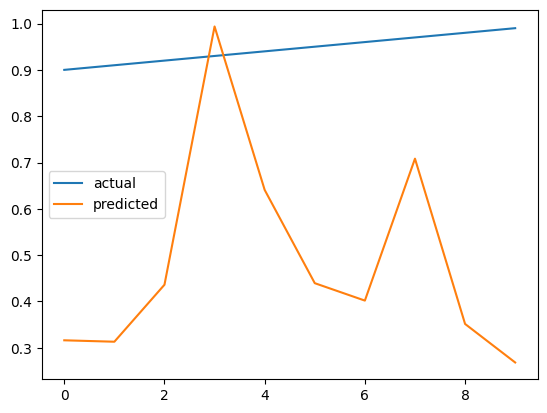

In [54]:
preds = model.forecast(horizon=n_test)
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-n_test:], label='actual')
plt.plot(preds.variance.values[0], label='predicted')
plt.legend()
plt.show()

In [66]:
preds.variance

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
89,0.316244,0.313171,0.436199,0.993662,0.640882,0.439546,0.40196,0.708318,0.351547,0.268369


### Financial Data

In [59]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [58]:
industrial_production = pd.read_csv("industrial_production_1988_2023.csv")
nasdaq = pd.read_csv("nasdaq_1990_2023.csv")

industrial_production = industrial_production.set_index("DATE")
nasdaq = nasdaq.set_index("DATE")

industrial_production = industrial_production['IPGMFN']
nasdaq = nasdaq['NASDAQCOM']

In [60]:
nasdaq_returns = np.log(nasdaq).diff().dropna().mul(100)

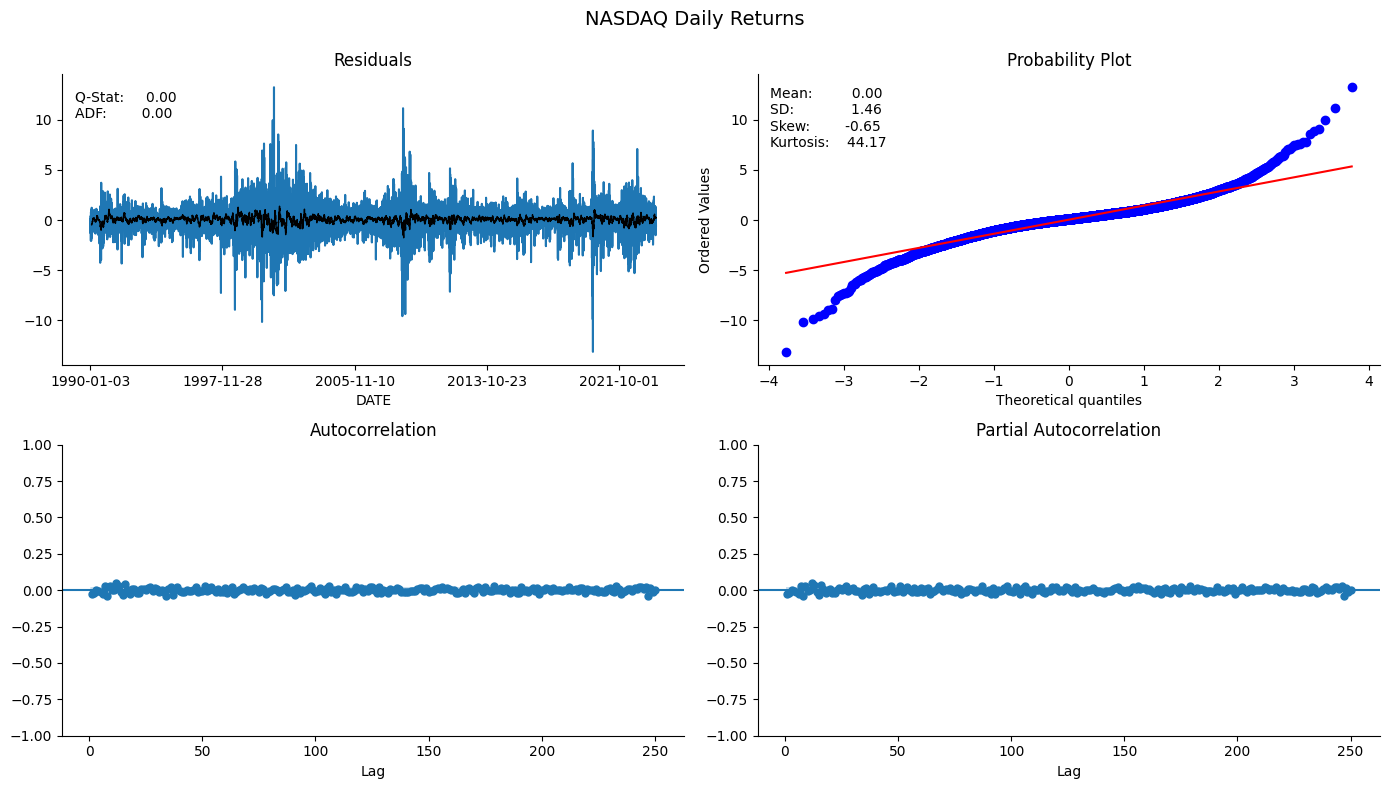

In [61]:
plot_correlogram(nasdaq_returns, lags=250, title='NASDAQ Daily Returns')

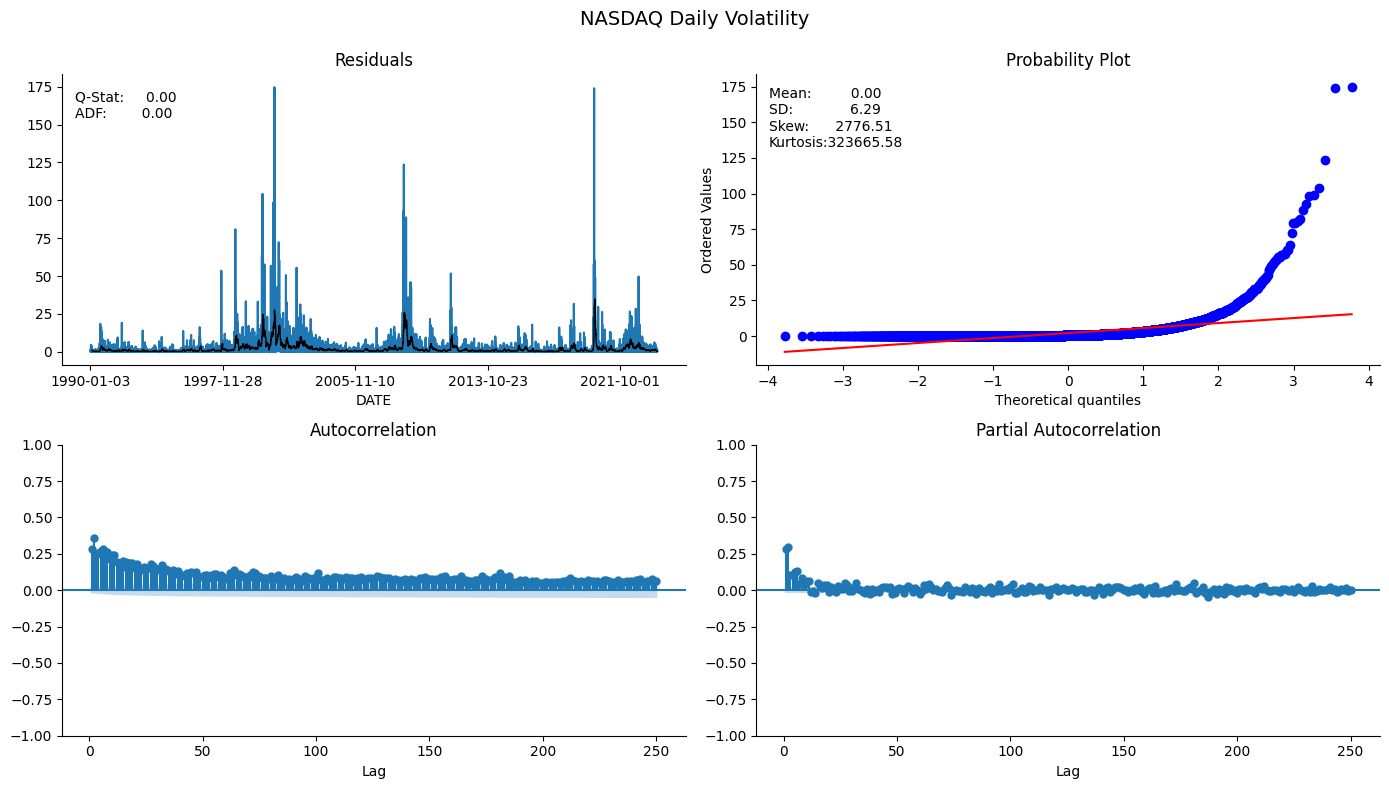

In [62]:
plot_correlogram(nasdaq_returns.sub(nasdaq_returns.mean()).pow(2), lags=250, title='NASDAQ Daily Volatility')

##### Model Selection

In [71]:
train_size = 10*252
data = nasdaq_returns.clip(lower = nasdaq_returns.quantile(0.05),
                           upper = nasdaq_returns.quantile(0.95))

T = len(nasdaq_returns)
results = {}

for p in range(1,3):
    for q in range(1,3):
        print(p, q)
        result = []
        for s, t in enumerate(range(train_size, T - 1)):
            print("Predicting for ",max(data[s:t].index))
            train_set = data[s:t]
            test_set = data[t + 1]
            model = arch_model(train_set, p = p, q = q).fit(disp='off')
            forecast = model.forecast(horizon = 1)
            mu = forecast.mean.iloc[-1, 0]
            var = forecast.variance.iloc[-1, 0]
            result.append([(test_set - mu) ** 2, var])
        df = pd.DataFrame(result, columns = ['y_true', 'y_pred'])
        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))



1 1
Predicting for  1999-12-21
Predicting for  1999-12-22
Predicting for  1999-12-23
Predicting for  1999-12-27
Predicting for  1999-12-28
Predicting for  1999-12-29
Predicting for  1999-12-30
Predicting for  1999-12-31
Predicting for  2000-01-03
Predicting for  2000-01-04
Predicting for  2000-01-05
Predicting for  2000-01-06
Predicting for  2000-01-07
Predicting for  2000-01-10
Predicting for  2000-01-11


Predicting for  2000-01-12
Predicting for  2000-01-13
Predicting for  2000-01-14
Predicting for  2000-01-18
Predicting for  2000-01-19
Predicting for  2000-01-20
Predicting for  2000-01-21
Predicting for  2000-01-24
Predicting for  2000-01-25
Predicting for  2000-01-26
Predicting for  2000-01-27
Predicting for  2000-01-28
Predicting for  2000-01-31
Predicting for  2000-02-01
Predicting for  2000-02-02
Predicting for  2000-02-03
Predicting for  2000-02-04
Predicting for  2000-02-07
Predicting for  2000-02-08
Predicting for  2000-02-09
Predicting for  2000-02-10
Predicting for  2000-02-11
Predicting for  2000-02-14
Predicting for  2000-02-15
Predicting for  2000-02-16
Predicting for  2000-02-17
Predicting for  2000-02-18
Predicting for  2000-02-22
Predicting for  2000-02-23
Predicting for  2000-02-24
Predicting for  2000-02-25
Predicting for  2000-02-28
Predicting for  2000-02-29
Predicting for  2000-03-01
Predicting for  2000-03-02
Predicting for  2000-03-03
Predicting for  2000-03-06
P

In [72]:
s = pd.Series(results)
s.index.names = ['p', 'q']
s = s.unstack().sort_index(ascending=False)

Text(0.5, 1.0, 'Out-of-Sample RMSE')

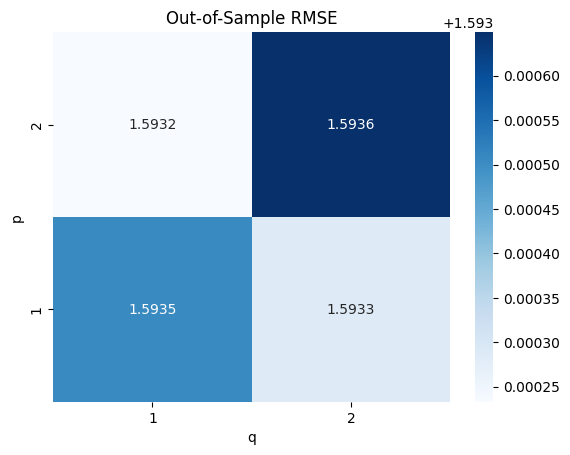

In [74]:
sns.heatmap(s, cmap='Blues', annot=True, fmt='.4f')
plt.title('Out-of-Sample RMSE')

In [75]:
best_p, best_q = 2, 2

In [76]:
am = ConstantMean(nasdaq_returns.clip(lower=nasdaq_returns.quantile(0.05),
                                      upper=nasdaq_returns.quantile(0.95)))
am.volatility = GARCH(best_p, 0, best_q)
am.distribution = Normal()
best_model = am.fit(update_freq = 5)
print(best_model.summary())

Iteration:      5,   Func. Count:     48,   Neg. LLF: 12508.450922449496
Iteration:     10,   Func. Count:     88,   Neg. LLF: 12411.722783264724
Iteration:     15,   Func. Count:    126,   Neg. LLF: 12408.785825959649
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12408.785825022262
            Iterations: 16
            Function evaluations: 133
            Gradient evaluations: 16
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              NASDAQCOM   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12408.8
Distribution:                  Normal   AIC:                           24829.6
Method:            Maximum Likelihood   BIC:                           24871.9
                                        No. Observations:                 8565
Date:            

In [ ]:
fig = best_model.plot